In [18]:
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

This was a quickly abandoned investigation into using tensor decompositions to investigate neural spiking data (a la Alex Williams and Scott Linderman).

In [2]:
import scipy.io as spio


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
DATA_PATH = '../'
binnedPRE = loadmat(DATA_PATH + 'binnedPBEs_PRE.mat')['binnedPBEs_PRE']
binnedRUN = loadmat(DATA_PATH + 'binnedPBEs_RUN.mat')['binnedPBEs_RUN']
binnedPOST = loadmat(DATA_PATH + 'binnedPBEs_POST.mat')['binnedPBEs_POST']

In [29]:
a = binnedPRE[4][0]
a[:,-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=uint8)

In [50]:
pbes = [a[1] for a in binnedPRE]

In [51]:
dims = [a.shape[1] for a in pbes]

In [52]:
max_dim = max(dims)

In [54]:
pbes = [np.pad(a,[(0,0),(0, max_dim - a.shape[1])]) for a in pbes]

In [55]:
pbes = np.array(pbes)

In [56]:
pbes.shape

(4670, 137, 55)

In [57]:
pbes = np.transpose(pbes,(1,2,0))

In [58]:
pbes.shape

(137, 55, 4670)

In [47]:
import numpy as np
import copy
from functools import reduce, partial
from scipy import linalg as spla

In [48]:
def khatri_rao(A,B):
    return np.vstack([np.kron(A[:, k], B[:, k]) for k in range(B.shape[1])]).T

def reorder(indices, mode):
    """Reorders the elements
    """
    indices = list(indices)
    element = indices.pop(mode)
    return ([element] + indices[::-1])

def unfold(tensor, mode=0):
    """Returns the mode-`mode` unfolding of `tensor`
        Only works on 3-D arrays currently
    """
    return np.transpose(tensor, reorder(range(tensor.ndim), mode)).reshape((tensor.shape[mode], -1))

def rank_one_reconstruction(A_n, lam, ncomp, dims):
    recon = [reduce(np.kron, [a[:,i] for a in A_n]).reshape(dims) for i in range(ncomp)]
    return np.sum((lam*(np.array(recon).T)).T, axis=0)

def unfold_all(tensor):
    return [unfold(tensor, mode=i) for i in range(tensor.ndim)]

def get_dist(unfolded_tensor, factors, lam):
    dist = 0
    for i, factor in enumerate(factors):
        temp_An = copy.deepcopy(factors)
        temp_An.pop(i)
        K = reduce(spla.khatri_rao, temp_An[::-1]).T
        dist = dist + np.linalg.norm(unfolded_tensor[i]-np.diag(lam).dot(factor.T).T.dot(K))
    return dist
def AtA(A):
    return np.dot(A.T, A)

In [49]:
def cp_als_v2(tensor, ncomp, eps=1e-5, max_iter=100, verbose=False):
    nmodes = len(tensor.shape)
    dims = tensor.shape
    A_n = [np.random.randn(dim, ncomp) for dim in dims]
    unfolded_t = unfold_all(tensor)
    dist = 1
    lam = np.zeros(ncomp)
    it = 0
    while dist > eps and it <= max_iter:
        for i in range(nmodes):
            temp_An = copy.deepcopy(A_n)
            temp_An.pop(i)
            V = reduce(np.multiply, list((map(AtA,temp_An))))
            K = reduce(spla.khatri_rao, list(reversed(temp_An)))
            A_n[i] = np.dot(unfolded_t[i], K).dot(np.linalg.pinv(V))
            lam = np.linalg.norm(A_n[i], axis = 0)
            A_n[i] = A_n[i] / lam
        dist = get_dist(unfolded_t, A_n, lam)
        it = it+1
        if verbose:
            print(f'Iteration {i}, distance = {dist}')
    return lam, A_n, dist, it

In [68]:
decomp = cp_als_v2(pbes[:,:,:100],ncomp=80, max_iter=200)

In [69]:
decomp[2]

184.36784621627834

In [71]:
pbes[:,:,:100].shape

(137, 55, 100)

In [72]:
from sklearn.decomposition import PCA

In [95]:
pca = PCA().fit(pbes[:,:,1])

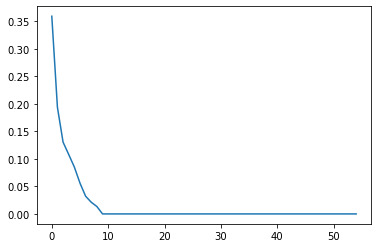

In [96]:
plt.plot(pca.explained_variance_ratio_)

In [87]:
dims

[15,
 10,
 6,
 6,
 10,
 6,
 6,
 7,
 11,
 9,
 8,
 6,
 6,
 5,
 11,
 10,
 10,
 8,
 6,
 9,
 7,
 5,
 10,
 14,
 7,
 7,
 9,
 7,
 12,
 6,
 8,
 8,
 8,
 25,
 17,
 7,
 6,
 13,
 7,
 5,
 13,
 5,
 10,
 9,
 7,
 4,
 15,
 8,
 8,
 21,
 13,
 9,
 8,
 4,
 14,
 5,
 6,
 17,
 3,
 7,
 19,
 5,
 4,
 6,
 7,
 5,
 13,
 7,
 6,
 14,
 9,
 5,
 9,
 11,
 9,
 5,
 4,
 9,
 11,
 3,
 13,
 6,
 19,
 7,
 16,
 8,
 10,
 12,
 6,
 4,
 14,
 8,
 6,
 7,
 10,
 6,
 15,
 8,
 6,
 9,
 14,
 9,
 7,
 7,
 9,
 6,
 7,
 8,
 9,
 5,
 7,
 8,
 9,
 6,
 26,
 26,
 9,
 12,
 5,
 12,
 6,
 4,
 9,
 7,
 10,
 12,
 5,
 9,
 12,
 16,
 9,
 4,
 6,
 5,
 14,
 11,
 18,
 24,
 6,
 26,
 17,
 11,
 12,
 16,
 14,
 6,
 13,
 9,
 14,
 7,
 3,
 3,
 16,
 7,
 11,
 5,
 37,
 48,
 7,
 9,
 14,
 9,
 3,
 3,
 11,
 12,
 12,
 12,
 4,
 10,
 11,
 7,
 8,
 6,
 14,
 9,
 6,
 7,
 13,
 6,
 8,
 6,
 8,
 10,
 11,
 5,
 10,
 14,
 7,
 8,
 12,
 24,
 22,
 18,
 7,
 5,
 10,
 9,
 10,
 9,
 26,
 3,
 8,
 12,
 8,
 6,
 8,
 6,
 27,
 4,
 15,
 19,
 8,
 5,
 4,
 10,
 6,
 5,
 8,
 10,
 5,
 23,
 9,
 20,
 10,
 8,
 11,
 5,


In [92]:
np.argmax(dims)

253

In [102]:
np.min(np.average(pbes, axis=2))

0.0